In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
import inference

In [2]:
import cv2

In [3]:
pipe = inference.InferencePipeline(model_path="Mask2_B_resizeFalse_crop512_tiny_150.pt")

In [4]:
image_path1 = "image_client/38200/IMG_PNEO3_202308091037033_PMS-FS_ORT_417a75c7-06d7-46c7-c61b-bd9e17f567ab_RGB_R1C1.TIF"
image_path0 = "image_client/38200/IMG_PNEO4_202205111036334_PMS-FS_ORT_999d0cef-9f8e-4176-c158-3cb7cb764895_RGB_R1C1.TIF"


In [5]:

transform = T.Compose([T.ToTensor(),
                    #    T.Resize(),
                       ])

In [6]:
seg0, seg1 = pipe.compare(image_path0, image_path1)

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

In [7]:
seg = seg1 - seg0

In [8]:
sobelx = cv2.Sobel(seg0.numpy(), cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(seg0.numpy(), cv2.CV_64F, 0, 1, ksize=5)

# Step 2: Compute the gradient direction
gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
gradient_direction = np.arctan2(sobely, sobelx) * (180 / np.pi)

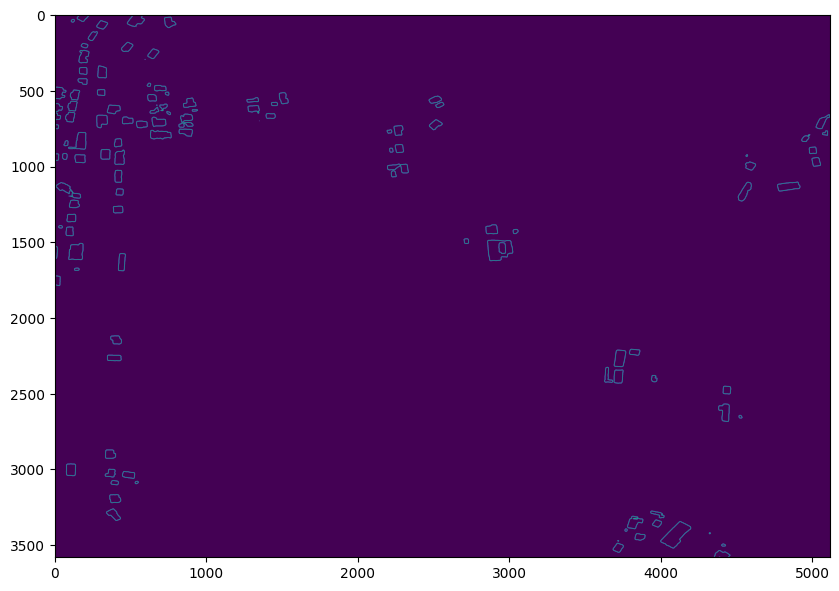

In [9]:
plt.figure(figsize=(10, 8))
plt.imshow(gradient_magnitude)

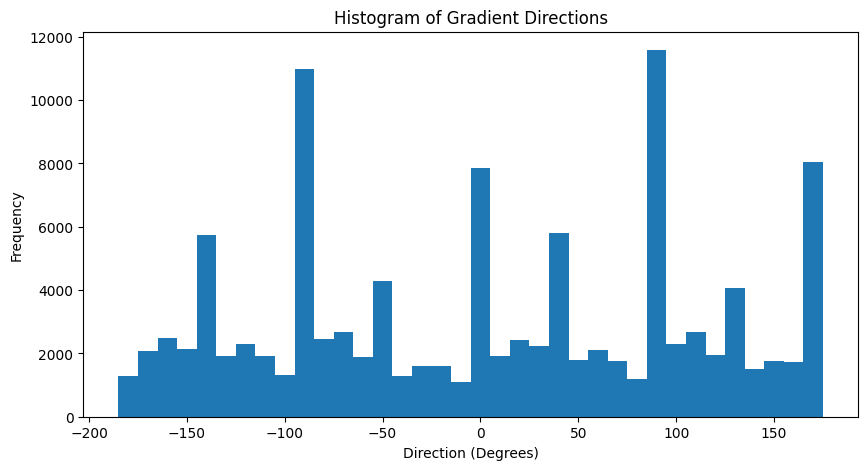

The dominant direction is: 90.0 degrees


In [10]:
import pandas as pd
# Flatten the gradient direction array and filter out low magnitudes
direction_flattened = gradient_direction.flatten()
magnitude_flattened = gradient_magnitude.flatten()

# Filter out the directions where the magnitude is low (e.g., below a threshold)
threshold = np.percentile(magnitude_flattened, 90)  # Consider top 10% of the magnitudes
filtered_directions = direction_flattened[magnitude_flattened > threshold]

# Step 3: Compute the histogram of gradient directions
hist, bin_edges = np.histogram(filtered_directions, bins=36, range=(-180, 180))

# Create a dataframe to display
gradient_hist_df = pd.DataFrame({
    "Direction (Degrees)": bin_edges[:-1],
    "Frequency": hist
})

# Find the dominant direction
dominant_direction = bin_edges[np.argmax(hist)]

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(gradient_hist_df["Direction (Degrees)"], gradient_hist_df["Frequency"], width=10)
plt.xlabel("Direction (Degrees)")
plt.ylabel("Frequency")
plt.title("Histogram of Gradient Directions")
plt.show()

print(f"The dominant direction is: {dominant_direction} degrees")

In [11]:
dominant_direction = bin_edges[np.argmax(hist)]

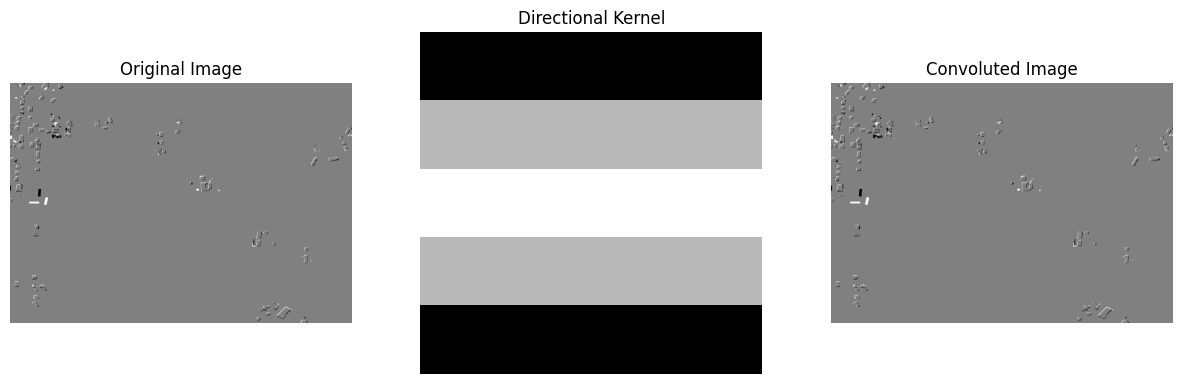

In [12]:
# Step 4: Create a directional kernel based on the dominant direction
angle_rad = np.deg2rad(dominant_direction)  # Convert degrees to radians
size = 5  # Kernel size, can be adjusted
directional_kernel = np.zeros((size, size))

# Define the directional kernel
for i in range(size):
    for j in range(size):
        y = i - size // 2
        x = j - size // 2
        directional_kernel[i, j] = np.exp(-((x * np.cos(angle_rad) + y * np.sin(angle_rad)) ** 2) / (2 * (size / 2) ** 2))

# Normalize the kernel
directional_kernel /= np.sum(directional_kernel)

# Step 5: Apply the directional kernel to the image
convoluted_image = cv2.filter2D(seg.numpy(), -1, directional_kernel)

# Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(seg, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Directional Kernel")
plt.imshow(directional_kernel, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Convoluted Image")
plt.imshow(convoluted_image, cmap='gray')
plt.axis('off')

plt.show()

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 129602.0
        x: [ 1.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00
             0.000e+00  0.000e+00  0.000e+00  1.000e+00]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00  0.000e+00]
     nfev: 10
     njev: 1
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>


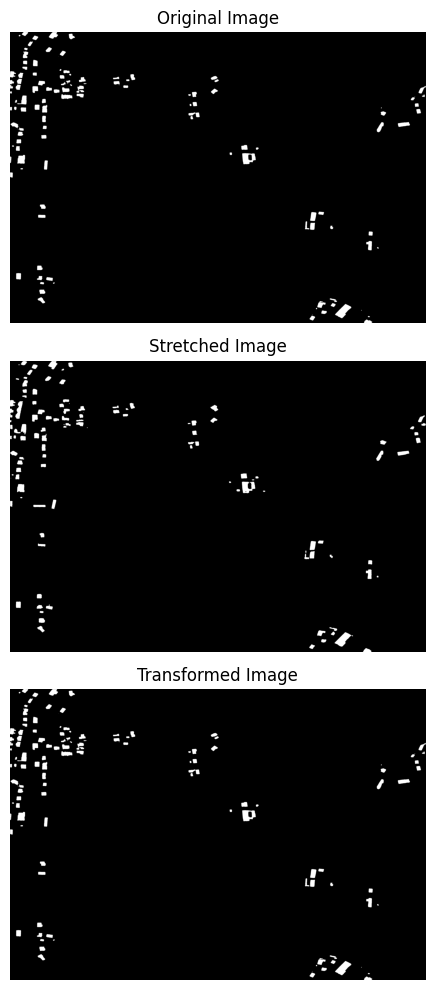

The stretching direction is: 0.00 degrees


In [13]:
import cv2
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load the original and stretched images
# original_image_path = "path_to_original_image.png"  # Replace with your original image path
# stretched_image_path = "path_to_stretched_image.png"  # Replace with your stretched image path
# original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
# stretched_image = cv2.imread(stretched_image_path, cv2.IMREAD_GRAYSCALE)

# Resize images to the same size for simplicity
# stretched_image = cv2.resize(stretched_image, (original_image.shape[1], original_image.shape[0]))

# Define the affine transformation model
def affine_transform(params, src, dst):
    M = np.array([[params[0], params[1], params[2]],
                  [params[3], params[4], params[5]],
                  [0, 0, 1]])
    transformed_image = cv2.warpAffine(src, M[:2], (src.shape[1], src.shape[0]))
    return transformed_image

# Define the objective function to minimize
def objective_function(params, src, dst):
    transformed_image = affine_transform(params, src, dst)
    return np.sum((transformed_image - dst) ** 2)

# Initial guess for the transformation matrix parameters (identity matrix)
initial_params = [1, 0, 0, 0, 1, 0, 0, 0, 1]

# Optimize the transformation matrix parameters
result = minimize(objective_function, initial_params, args=(seg0.numpy(), seg1.numpy()), method='L-BFGS-B')

# Extract the optimal parameters
print(result)
optimal_params = result.x
optimal_matrix = np.array([[optimal_params[0], optimal_params[1], optimal_params[2]],
                           [optimal_params[3], optimal_params[4], optimal_params[5]],
                           [optimal_params[6], optimal_params[7], optimal_params[8]]])

# Apply the optimal transformation
transformed_image = affine_transform(optimal_params, seg0.numpy(), seg1.numpy())

# Calculate stretching direction (angle)
angle_rad = np.arctan2(optimal_matrix[0, 1], optimal_matrix[0, 0])
stretching_direction = np.degrees(angle_rad)

# Display the results
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(seg0.numpy(), cmap='gray')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.title("Stretched Image")
plt.imshow(seg1.numpy(), cmap='gray')
plt.axis('off')

plt.subplot(3, 1, 3)
plt.title("Transformed Image")
plt.imshow(transformed_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"The stretching direction is: {stretching_direction:.2f} degrees")

In [14]:
def create_stretch_matrix(theta, s):
    d = np.array([np.cos(theta), np.sin(theta)])
    stretch_matrix = np.eye(2) + (s - 1) * np.outer(d, d)
    return stretch_matrix
stretch_matrix = create_stretch_matrix(0.5, 1.5)

In [15]:
stretch_matrix_2x3 = np.hstack([stretch_matrix, np.array([[0], [0]])])
stretched_image = cv2.warpAffine(seg0.numpy(), stretch_matrix_2x3, dsize=(seg0.shape[1], seg0.shape[0]))

In [16]:
def compare(img, img_ref, params):
    stretch_matrix = create_stretch_matrix(params[0], params[1])
    stretch_matrix_2x3 = np.hstack([stretch_matrix, np.array([[params[2]], [params[3]]])])
    stretched_image = cv2.warpAffine(img, stretch_matrix_2x3, dsize=(img.shape[1], img.shape[0]))
    return np.sum((stretched_image - img_ref) ** 2)

In [17]:
def func(params):
    return compare(seg0.numpy(), seg1.numpy(), params)

In [18]:
minimize(func, [0.1, 0.1, 0.1, 0.1]).x

array([ 0.6602472, -0.7403708,  0.1      ,  0.1      ])

In [19]:
stretch_matrix_2x3 = np.hstack([create_stretch_matrix(0.6602472, 0.7403708), np.array([[0.1], [0.1]])])
stretched_image = cv2.warpAffine(seg0.numpy(), stretch_matrix_2x3, dsize=(seg0.shape[1], seg0.shape[0]))

In [20]:
kernel = np.eye(11)
kernel2 = np.fliplr(kernel)

kernel_rec = np.ones((11, 11))

In [21]:
kernel_cross =  (kernel + kernel2)
kernel_cross[5, 5] = 1.

In [22]:
filtered = cv2.filter2D((seg1-seg0).numpy(), -1, kernel/np.sum(kernel))
filtered = np.where(filtered > 0.8, 1., np.where(filtered < -0.8, -1., 0.))

filtered = cv2.filter2D(filtered, -1, kernel2/np.sum(kernel2))
filtered = np.where(filtered > 0.8, 1., np.where(filtered < -0.8, -1., 0.))

filtered = cv2.filter2D(filtered, -1, kernel_rec)
filtered = np.where(filtered >= 1., 1., np.where(filtered <= -1., -1., 0.))

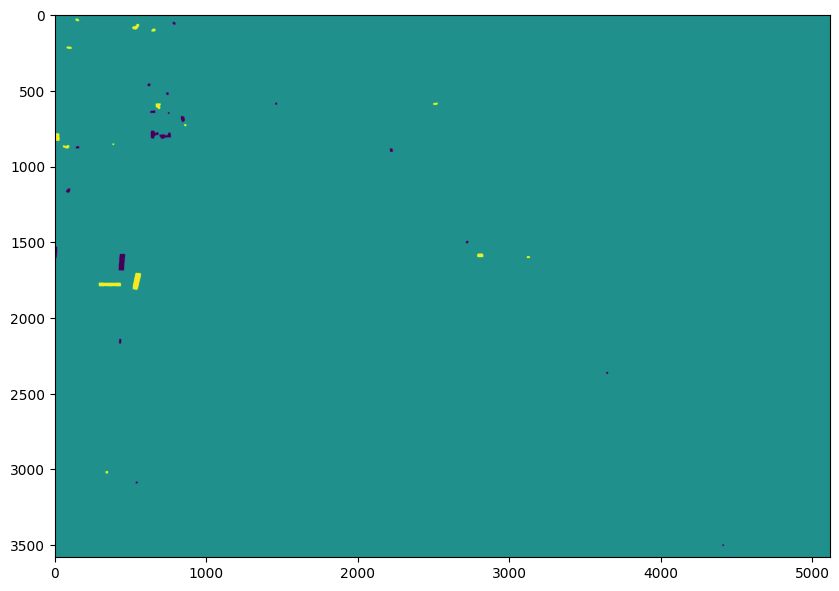

In [23]:
plt.figure(figsize=(10, 8))
plt.imshow(filtered)

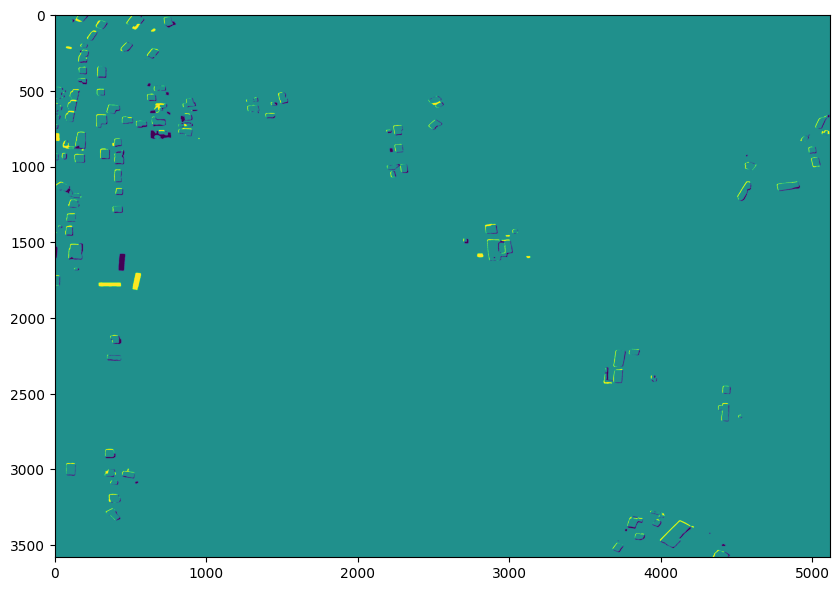

In [24]:
plt.figure(figsize=(10, 8))
plt.imshow(seg1-seg0)

In [25]:
img0 = Image.open(image_path0)

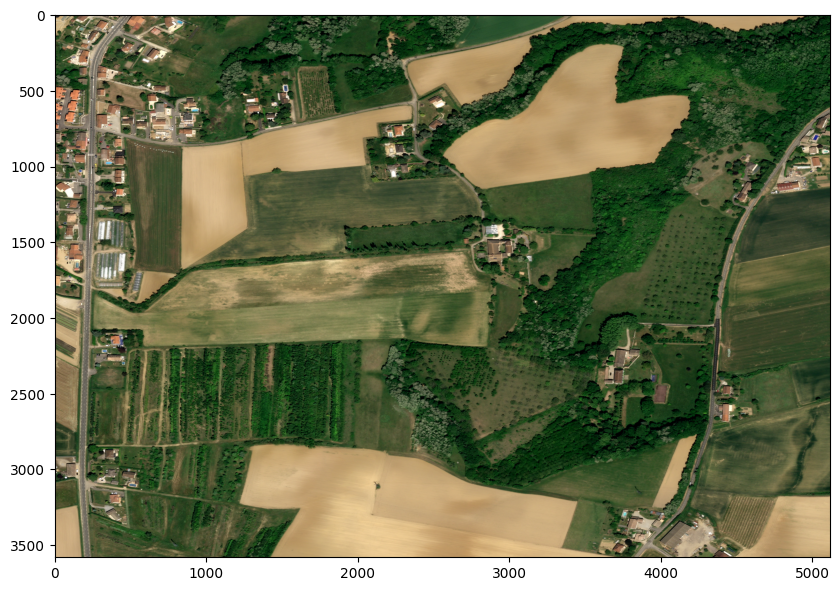

In [26]:
plt.figure(figsize=(10, 8))
plt.imshow(img0) #hangar